In [56]:
import sys
import cantera as ct
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

import phases
import feedstock as fs
import fuel as fu
import energy as en
import gasifier as gs

In [57]:
ultimate = [46.76, 5.76, 45.83, 0.22, 0.67, 0] # %m/m, dry basis
moistWB = 0.1245 # fraction, wet basis
ashWB = 0.0077 # fraction, wet basis
GCV = 17.36 # MJ/kg

moistDB = moistWB / (1 - moistWB)
ashDB = ashWB / (1 - moistWB)

conv = (phases.Pn) * (phases.Mw_air) / (phases.R * phases.Tn)

In [58]:
feedRate = np.array([1.73, 2.15, 2.64, 3.19, 3.69, 4.02, 4.06, 4.48, 4.70, 4.93, 5.40]) # kg/h of wet fuel
airRatio = np.array([1.63, 1.64, 1.52, 1.38, 1.51, 1.46, 1.47, 1.44, 1.37, 1.48, 1.50]) # Nm³/kg
dryFeedRate = (1 - moistWB) * feedRate # kg/h of dry fuel
airFlow = conv * airRatio * feedRate # kg/h of air

In [59]:
H2_exp = np.array([14.77, 14.62, 14.77, 14.77, 14.12, 13.13, 12.67, 11.86, 13.83, 11.33, 11.11])
N2_exp = np.array([58.67, 59.67, 56.96, 57.05, 57.07, 53.33, 54.71, 53.95, 54.24, 55.65, 55.83])
CH4_exp = np.array([1.40, 2.10, 1.94, 2.03, 1.70, 2.18, 1.97, 2.47, 1.98, 2.36, 2.15])
CO_exp = np.array([8.56, 8.92, 12.08, 14.41, 16.80, 20.66, 19.63, 19.89, 18.41, 18.99, 18.56])
CO2_exp = np.array([16.33, 13.92, 13.02, 11.42, 9.93, 9.52, 10.02, 11.25, 11.12, 11.09, 11.22])
gasFlow_exp = np.array([3.55, 4.44, 5.33, 6.22, 7.26, 8.15, 8.15, 9.18, 9.48, 10.07, 10.96]) # Nm³/h
HHV_exp = np.array([3.47, 3.76, 4.22, 4.50, 4.55, 5.12, 4.96, 5.15, 4.75, 4.86, 4.66]) # MJ/Nm³
gasYield_exp = gasFlow_exp / feedRate
print(gasYield_exp)

[2.05202312 2.06511628 2.01893939 1.94984326 1.96747967 2.02736318
 2.00738916 2.04910714 2.01702128 2.04259635 2.02962963]


In [60]:
fuels = []
airs = []
ERs = np.zeros_like(feedRate)
outlets = []

for i, dryFeed in enumerate(dryFeedRate):
    fuel = fs.create_fuel_stream(dryFeed, ultimate, ashDB, moistDB, GCV)
    fuels.append(fuel)
    air = fs.create_air_stream(airFlow[i])
    airs.append(air)
    outlet = gs.gasify_nonisot(fuel, air, heatLossFraction=0.1)
    outlets.append(outlet)
    stoichAir = fs.create_air_from_ER(fuel, 1.0)
    ER = air.get_mass() / stoichAir.get_mass()
    ERs[i] = ER

-12.914648899468752 2.6293716400000005
-16.04999718719373 3.2677161999999997
-19.707903522987667 4.01245152
-23.813716757095627 4.848378919999999
-27.546274242370327 5.6083129199999995
-30.009762182813418 6.109869359999999
-30.308366781633545 6.17066408
-33.44371506943457 6.809008639999999
-35.086040363134934 7.1433795999999985
-36.80301680625253 7.492949239999998
-40.311620842511644 8.207287199999998


In [68]:
syngasHHV = np.array([out.get_syngas_hhv(basis='vol', water=False, nitrogen=True) for out in outlets])
syngasFlow = np.array([out.get_syngas_amount(basis='vol', water=False, nitrogen=True) for out in outlets])
syngasYield = syngasFlow / feedRate
temperatures = np.array([out.T for out in outlets]) # K
H2 = np.array([100*out.get_syngas_fraction(species='H2', water=False, nitrogen=True) for out in outlets])
N2 = np.array([100*out.get_syngas_fraction(species='N2', water=False, nitrogen=True) for out in outlets])
CH4 = np.array([100*out.get_syngas_fraction(species='CH4', water=False, nitrogen=True) for out in outlets])
CO = np.array([100*out.get_syngas_fraction(species='CO', water=False, nitrogen=True) for out in outlets])
CO2 = np.array([100*out.get_syngas_fraction(species='CO2', water=False, nitrogen=True) for out in outlets])
print(temperatures-273.15)

[1166.64892746 1170.92418387 1117.55877239 1049.01523662 1112.89888931
 1089.07254713 1093.90950294 1079.28799235 1043.83056008 1098.71017834
 1108.20444246]


In [62]:
char_params = np.array([-111.1574, 3.9705, 0.0362, -7.1958, 3.0419, 1.2430, 0.1276, 1.1034, 1.4281])
methane_params = np.array([16.5264, 0.4982, -0.0304, 0.1739, 0.2148, -0.1864, -0.1186, -0.2192, -0.2552])

def char(ER, MC, T, C, H, O, ash):
    a = lambda i: char_params[i]
    return np.exp(a(0) + a(1)*ER + a(2)*MC + a(3)*((10**(-3))*T) + a(4)*((10**(-3))*T)**2 + a(5)*C + a(6)*H + a(7)*O +a(8)*ash)

def met(ER, MC, T, C, H, O, ash):
    b = lambda i: methane_params[i]
    return np.exp(b(0) + b(1)*ER + b(2)*MC + b(3)*((10**(-3))*T) + b(4)*((10**(-3))*T)**2 + b(5)*C + b(6)*H + b(7)*O +b(8)*ash)

In [63]:
outlets_char = []
for i, fuel in enumerate(fuels):
    air = airs[i]
    ER = ERs[i]
    T = temperatures[i]
    # charFormation = char(ER, 100*moistDB, T, ultimate[0], ultimate[1], ultimate[2], 100*ashDB)
    # charFormation = 1 - (0.25 + 0.75*np.exp(-ER/0.23))
    # charFormation = 0.0647*ER*T**0.3 + 0.465
    charFormation = 0.05
    methaneConversion = met(ER, 100*moistDB, T, ultimate[0], ultimate[1], ultimate[2], 100*ashDB)
    # print(charFormation, methaneConversion)
    outlet = gs.gasify_nonisot(fuel, air, charFormation=0.05, directMethaneConv=0, heatLossFraction=0.1)
    outlets_char.append(outlet)

syngasHHV_char = np.array([out.get_syngas_hhv(basis='vol', water=False, nitrogen=True) for out in outlets_char])
syngasFlow_char = np.array([out.get_syngas_amount(basis='vol', water=False, nitrogen=True) for out in outlets_char])
syngasYield_char = syngasFlow_char / feedRate
temperatures_char = np.array([out.T for out in outlets_char]) # K
H2_char = np.array([100*out.get_syngas_fraction(species='H2', water=False, nitrogen=True) for out in outlets_char])
N2_char = np.array([100*out.get_syngas_fraction(species='N2', water=False, nitrogen=True) for out in outlets_char])
CH4_char = np.array([100*out.get_syngas_fraction(species='CH4', water=False, nitrogen=True) for out in outlets_char])
CO_char = np.array([100*out.get_syngas_fraction(species='CO', water=False, nitrogen=True) for out in outlets_char])
CO2_char = np.array([100*out.get_syngas_fraction(species='CO2', water=False, nitrogen=True) for out in outlets_char])

-12.914648899468752 2.6293716400000005
-16.04999718719373 3.2677161999999997
-19.707903522987667 4.01245152
-23.813716757095627 4.848378919999999
-27.546274242370327 5.6083129199999995
-30.009762182813418 6.109869359999999
-30.308366781633545 6.17066408
-33.44371506943457 6.809008639999999
-35.086040363134934 7.1433795999999985
-36.80301680625253 7.492949239999998
-40.311620842511644 8.207287199999998


In [64]:
outlets_met = []
for i, fuel in enumerate(fuels):
    air = airs[i]
    ER = ERs[i]
    T = temperatures[i]
    charFormation = char(ER, 100*moistDB, T, ultimate[0], ultimate[1], ultimate[2], 100*ashDB)
    methaneConversion = met(ER, 100*moistDB, T, ultimate[0], ultimate[1], ultimate[2], 100*ashDB)
    # print(charFormation, methaneConversion)
    outlet = gs.gasify_nonisot(fuel, air, charFormation=0, directMethaneConv=0.05, heatLossFraction=0.1)
    outlets_met.append(outlet)

syngasHHV_met = np.array([out.get_syngas_hhv(basis='vol', water=False, nitrogen=True) for out in outlets_met])
syngasFlow_met = np.array([out.get_syngas_amount(basis='vol', water=False, nitrogen=True) for out in outlets_met])
syngasYield_met = syngasFlow_met / feedRate
temperatures_met = np.array([out.T for out in outlets_met]) # K
H2_met = np.array([100*out.get_syngas_fraction(species='H2', water=False, nitrogen=True) for out in outlets_met])
N2_met = np.array([100*out.get_syngas_fraction(species='N2', water=False, nitrogen=True) for out in outlets_met])
CH4_met = np.array([100*out.get_syngas_fraction(species='CH4', water=False, nitrogen=True) for out in outlets_met])
CO_met = np.array([100*out.get_syngas_fraction(species='CO', water=False, nitrogen=True) for out in outlets_met])
CO2_met = np.array([100*out.get_syngas_fraction(species='CO2', water=False, nitrogen=True) for out in outlets_met])

-12.914648899468752 2.6293716400000005
-16.04999718719373 3.2677161999999997
-19.707903522987667 4.01245152
-23.813716757095627 4.848378919999999
-27.546274242370327 5.6083129199999995
-30.009762182813418 6.109869359999999
-30.308366781633545 6.17066408
-33.44371506943457 6.809008639999999
-35.086040363134934 7.1433795999999985
-36.80301680625253 7.492949239999998
-40.311620842511644 8.207287199999998


In [69]:
outlets_both = []
for i, fuel in enumerate(fuels):
    air = airs[i]
    ER = ERs[i]
    T = temperatures[i]
    charFormation = char(ER, 100*moistDB, T, ultimate[0], ultimate[1], ultimate[2], 100*ashDB)
    methaneConversion = met(ER, 100*moistDB, T, ultimate[0], ultimate[1], ultimate[2], 100*ashDB)
    print(charFormation, methaneConversion)
    outlet = gs.gasify_nonisot(fuel, air, charFormation=0.05, directMethaneConv=0.05, heatLossFraction=0.1)
    outlets_both.append(outlet)

syngasHHV_both = np.array([out.get_syngas_hhv(basis='vol', water=False, nitrogen=True) for out in outlets_both])
syngasFlow_both = np.array([out.get_syngas_amount(basis='vol', water=False, nitrogen=True) for out in outlets_both])
syngasYield_both = syngasFlow_both / feedRate
temperatures_both = np.array([out.T for out in outlets_both]) # K
H2_both = np.array([100*out.get_syngas_fraction(species='H2', water=False, nitrogen=True) for out in outlets_both])
N2_both = np.array([100*out.get_syngas_fraction(species='N2', water=False, nitrogen=True) for out in outlets_both])
CH4_both = np.array([100*out.get_syngas_fraction(species='CH4', water=False, nitrogen=True) for out in outlets_both])
CO_both = np.array([100*out.get_syngas_fraction(species='CO', water=False, nitrogen=True) for out in outlets_both])
CO2_both = np.array([100*out.get_syngas_fraction(species='CO2', water=False, nitrogen=True) for out in outlets_both])

0.10631202896410756 0.07013669462038369
-12.914648899468752 2.6293716400000005
0.10820184399973487 0.07047112217934347
-16.04999718719373 3.2677161999999997
0.0879946577185987 0.0664896862526213
-19.707903522987667 4.01245152
0.07028435683743121 0.06193427617244233
-23.813716757095627 4.848378919999999
0.08653665342143847 0.06616105646989529
-27.546274242370327 5.6083129199999995
0.07971305471288541 0.06452532474120531
-30.009762182813418 6.109869359999999
0.08101743383999965 0.06485147676392096
-30.308366781633545 6.17066408
0.0771910993340058 0.06387452391659472
-33.44371506943457 6.809008639999999
0.0692245178504384 0.0616126938928823
-35.086040363134934 7.1433795999999985
0.08235144116351148 0.06517812759074583
-36.80301680625253 7.492949239999998
0.08511049628657329 0.06583291905301653
-40.311620842511644 8.207287199999998


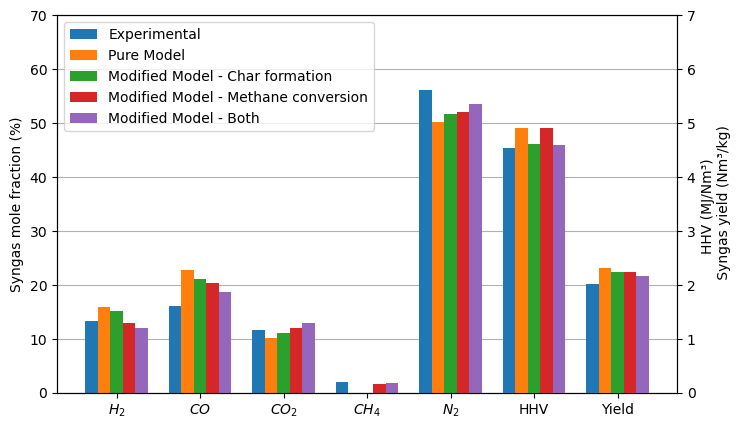

In [66]:
frac_groups = ['$H_2$', '$CO$', '$CO_2$', '$CH_4$', '$N_2$']
exp_frac = [np.average(H2_exp), np.average(CO_exp), np.average(CO2_exp), np.average(CH4_exp), np.average(N2_exp)]
pure_model_frac = [np.average(H2), np.average(CO), np.average(CO2), np.average(CH4), np.average(N2)]
char_model_frac = [np.average(H2_char), np.average(CO_char), np.average(CO2_char), np.average(CH4_char), np.average(N2_char)]
met_model_frac = [np.average(H2_met), np.average(CO_met), np.average(CO2_met), np.average(CH4_met), np.average(N2_met)]
both_model_frac = [np.average(H2_both), np.average(CO_both), np.average(CO2_both), np.average(CH4_both), np.average(N2_both)]

prop_groups = ['HHV', 'Yield']
exp_props = [np.average(HHV_exp), np.average(gasYield_exp)]
pure_model_props = [np.average(syngasHHV), np.average(syngasYield)]
char_model_props = [np.average(syngasHHV_char), np.average(syngasYield_char)]
met_model_props = [np.average(syngasHHV_met), np.average(syngasYield_met)]
both_model_props = [np.average(syngasHHV_both), np.average(syngasYield_both)]
  
X_axis1 = np.arange(len(frac_groups))
X_axis2 = np.arange(X_axis1[-1]+1, X_axis1[-1]+1+len(prop_groups))

w = 0.15

fig, ax1 = plt.subplots(figsize=(8,5), dpi=100)
ax1.bar(X_axis1 - 2*w, exp_frac, w, label='Experimental', zorder=3)
ax1.bar(X_axis1 - w, pure_model_frac, w, label='Pure model', zorder=3)
ax1.bar(X_axis1, char_model_frac, w, label='Modified model - Char formation', zorder=3)
ax1.bar(X_axis1 + w, met_model_frac, w, label='Modified model - Methane conversion', zorder=3)
ax1.bar(X_axis1 + 2*w, both_model_frac, w, label='Modified model - Both', zorder=3)
ax1.set_ylabel("Syngas mole fraction (%)")
ax1.grid(zorder=0, axis='y')
ax1.set_ylim(0, 70)

ax2 = ax1.twinx()
ax2.bar(X_axis2 - 2*w, exp_props, w, label='Experimental', zorder=3)
ax2.bar(X_axis2 - w, pure_model_props, w, label='Pure Model', zorder=3)
ax2.bar(X_axis2, char_model_props, w, label='Modified Model - Char formation', zorder=3)
ax2.bar(X_axis2 + w, met_model_props, w, label='Modified Model - Methane conversion', zorder=3)
ax2.bar(X_axis2 + 2*w, both_model_props, w, label='Modified Model - Both', zorder=3)
plt.xticks(np.append(X_axis1,X_axis2), frac_groups+prop_groups)
ax2.set_ylabel("HHV (MJ/Nm³) \n Syngas yield (Nm³/kg)")
ax2.set_ylim(0, 7)

plt.legend(loc='upper left')
plt.savefig('figures/drogu.png')
plt.show()